# 06_spatial_integration.ipynb

## Purpose

This notebook integrates spatial layers prepared in:

- 02_admin_boundaries
- 03_worldpop
- 05_nighttimelight

We align population and night-time light rasters into a common spatial grid,
clip them to the Sundarbans study region, and construct derived features
for downstream vulnerability analysis.

This notebook does NOT download or preprocess raw data.
It assumes intermediate raster outputs from 03 and 05 exist.

---

## Integration Steps

1. Load processed population raster (EPSG:4326 or 3857)
2. Load processed night-time light raster
3. Reproject both to common CRS (EPSG:3857)
4. Align resolution and grid extent
5. Clip to Sundarbans bounding box
6. Construct joint feature arrays:
   - Population density
   - Log-transformed NTL
   - Per-capita light intensity
7. Save integrated raster stack for modeling

Output:
- Integrated raster stack
- Diagnostic overlay plots

In [1]:
from pathlib import Path
import numpy as np
import rasterio
from rasterio.warp import reproject, calculate_default_transform, Resampling
import geopandas as gpd

In [2]:
from pathlib import Path
import numpy as np
import rasterio

# --- Paths ---
ROOT = Path("..")  # because notebooks typically run from notebooks/; adjust if needed
FP_POP = ROOT / "outputs/worldpop/worldpop_2019_ppp_3857.tif"

# --- Load WorldPop (EPSG:3857) ---
with rasterio.open(FP_POP) as src:
    pop = src.read(1).astype(np.float32)
    pop_transform = src.transform
    pop_crs = src.crs
    pop_bounds = src.bounds
    pop_res = src.res

print("WorldPop loaded")
print("  shape:", pop.shape)
print("  crs:", pop_crs)
print("  res (x,y):", pop_res)
print("  bounds:", pop_bounds)
print("  min/max:", np.nanmin(pop), np.nanmax(pop))

WorldPop loaded
  shape: (127, 167)
  crs: EPSG:3857
  res (x,y): (952.604543907588, 952.604543907588)
  bounds: BoundingBox(left=9851635.74727747, bottom=2451636.1996478587, right=10010720.706110038, top=2572616.976724122)
  min/max: 0.4811238 3851.1128


In [3]:
from shapely.geometry import box

# Integration CRS policy
INTEGRATION_CRS = "EPSG:3857"  # everything in 06 will align to this

# Sundarbans bbox (your CEAM values)
LON_MIN, LAT_MIN, LON_MAX, LAT_MAX = 88.08, 21.50, 89.92, 22.67
bbox_wgs84 = box(LON_MIN, LAT_MIN, LON_MAX, LAT_MAX)

print("Integration CRS:", INTEGRATION_CRS)
print("Sundarbans bbox (WGS84):", (LON_MIN, LAT_MIN, LON_MAX, LAT_MAX))

Integration CRS: EPSG:3857
Sundarbans bbox (WGS84): (88.08, 21.5, 89.92, 22.67)


In [6]:
bbox = {"lon_min": 88.5, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.5}

**Reproject to EPSG:3857 + overlay on hero PNG**

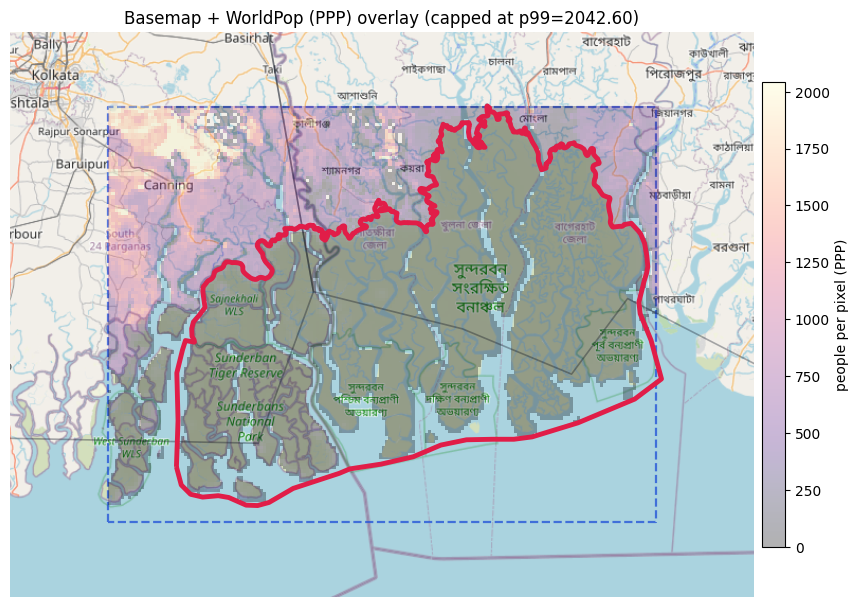

In [7]:
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from pyproj import Transformer
from rasterio.warp import calculate_default_transform, reproject, Resampling

# ---- 1) WorldPop is already EPSG:3857 in 06 ----
dst_crs = "EPSG:3857"

# extent for imshow, derived from the raster transform + shape
h, w = pop.shape
xmin, ymax = pop_transform * (0, 0)
xmax, ymin = pop_transform * (w, h)
pop_extent_3857 = [xmin, xmax, ymin, ymax]

pop_3857 = pop  # alias so the rest of your plotting code can stay unchanged

# ---- 2) Build bbox_3857 and padded extent EXACTLY like admin_boundaries ----
bbox_poly_4326 = box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])
bbox_3857 = gpd.GeoDataFrame(geometry=[bbox_poly_4326], crs="EPSG:4326").to_crs(epsg=3857)

bxmin, bymin, bxmax, bymax = bbox_3857.total_bounds
pad_x = (bxmax - bxmin) * 0.18
pad_y = (bymax - bymin) * 0.18
xlim = (bxmin - pad_x, bxmax + pad_x)
ylim = (bymin - pad_y, bymax + pad_y)

# ---- 3) Load overlays (or reuse your existing region_3857/sund_3857) ----
ne_path = "../data/basemaps/natural_earth/ne_110m_admin_0_countries.shp"
sund_path = "../data/basemaps/osm/sundarbans_relation_14937802.geojson"  # adjust if needed

region_3857 = gpd.read_file(ne_path).to_crs(epsg=3857)
sund = gpd.read_file(sund_path)
sund_3857 = sund[sund.geometry.type.isin(["Polygon", "MultiPolygon"])].to_crs(epsg=3857)

# ---- 4) Plot hero + WorldPop (PPP) with scale ----
valid = pop_3857[np.isfinite(pop_3857)]
p99 = np.percentile(valid, 99)
vmax = p99

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857", attribution=False)

region_3857.boundary.plot(ax=ax, color="#111827", linewidth=1.2, alpha=0.35, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=1.6, linestyle="--", alpha=0.75, zorder=5)
sund_3857.boundary.plot(ax=ax, color="#E11D48", linewidth=3.5, zorder=10)

im = ax.imshow(pop_3857, extent=pop_extent_3857, cmap="magma", alpha=0.3, vmin=0, vmax=vmax, zorder=6)

ax.set_title(f"Basemap + WorldPop (PPP) overlay (capped at p99={vmax:.2f})")
ax.axis("off")
cb = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
cb.set_label("people per pixel (PPP)")
plt.show()


In [8]:
import geopandas as gpd

sund = gpd.read_file("../data/basemaps/osm/sundarbans_relation_14937802.geojson")

# Keep only polygons (drop lines/points)
sund_poly = sund[sund.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

sund_3857 = sund_poly.to_crs(epsg=3857)

In [10]:
import numpy as np
from rasterio.features import geometry_mask

# pop_3857: float32 array with np.nan as nodata (as in your cell)
# dst_transform: affine transform for pop_3857
# sund_3857: GeoDataFrame in EPSG:3857

# 1) Total population in the (already clipped) bbox
pop_bbox_sum = np.nansum(pop_3857)

# 2) Mask for pixels INSIDE Sundarbans polygon
sund_union = sund_3857.geometry.unary_union
inside_mask = geometry_mask(
    [sund_union],
    out_shape=pop_3857.shape,
    transform=pop_transform,
    invert=True,        # True = inside polygon
    all_touched=False
)

pop_in_sund = np.where(inside_mask, pop_3857, np.nan)
pop_sund_sum = np.nansum(pop_in_sund)

# 3) Print results
print(f"Total pop in bbox (sum PPP over raster pixels): {pop_bbox_sum:,.0f}")
print(f"Total pop inside sund_3857 polygon:             {pop_sund_sum:,.0f}")
print(f"Share inside polygon:                           {100*pop_sund_sum/pop_bbox_sum:.2f}%")


Total pop in bbox (sum PPP over raster pixels): 4,669,585
Total pop inside sund_3857 polygon:             559,277
Share inside polygon:                           11.98%


/var/folders/d7/3y4pn1x55_583bts49jyqlxh0000gn/T/ipykernel_1497/651480545.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  sund_union = sund_3857.geometry.unary_union


In [13]:
# ---- Convert from people-per-pixel to people-per-sq-km (EPSG:3857 pixel area in m^2) ----
pixel_width_m  = pop_transform.a
pixel_height_m = abs(pop_transform.e)  # e is typically negative
pixel_area_m2  = pixel_width_m * pixel_height_m
pixel_area_km2 = pixel_area_m2 / 1e6

pop_density_km2 = pop_3857 / pixel_area_km2


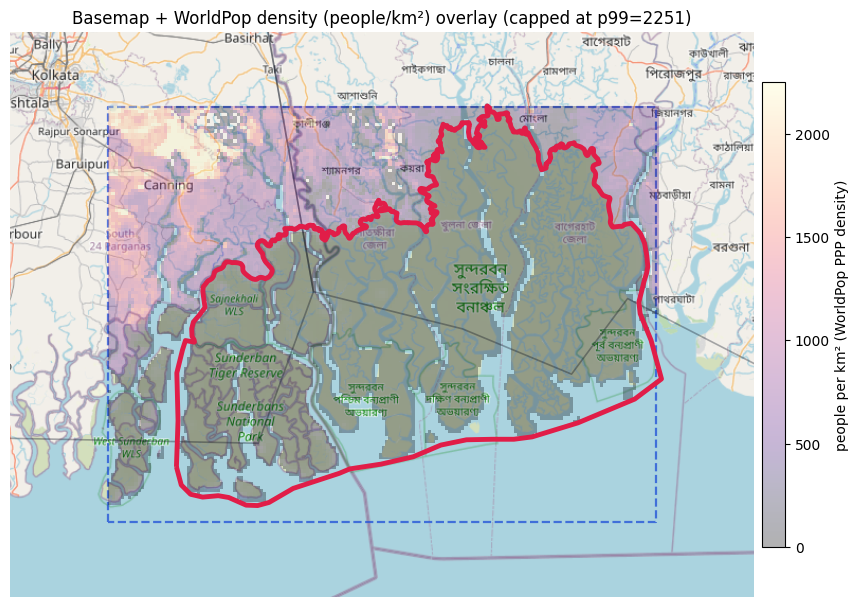

In [14]:
# ---- 4) Plot hero + WorldPop density with scale ----
valid = pop_density_km2[np.isfinite(pop_density_km2)]
p99 = np.percentile(valid, 99)
vmax = p99

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857", attribution=False)

region_3857.boundary.plot(ax=ax, color="#111827", linewidth=1.2, alpha=0.35, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=1.6, linestyle="--", alpha=0.75, zorder=5)
sund_3857.boundary.plot(ax=ax, color="#E11D48", linewidth=3.5, zorder=10)

im = ax.imshow(
    pop_density_km2,
    extent=pop_extent_3857,
    cmap="magma",
    alpha=0.3,
    vmin=0,
    vmax=vmax,
    zorder=6
)

ax.set_title(f"Basemap + WorldPop density (people/km²) overlay (capped at p99={vmax:.0f})")
ax.axis("off")
cb = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.01)
cb.set_label("people per km² (WorldPop PPP density)")
plt.show()
